<a href="https://colab.research.google.com/github/y001003/yeardream/blob/main/DL/torch/14-dnn_2/14_07_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with Deep Neural Networks

## 1 Load MNIST Dataset

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
from torchvision import datasets, transforms

In [7]:
# torchvision에서 MNIST 데이터셋을 불러온다
train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

In [8]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)

    plt.imshow(img, cmap='gray')
    plt.show()

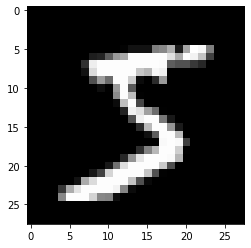

In [9]:
plot(train.data[0])

MINST 데이터셋

세로 28, 가로 28 픽셀 train 60,000개 test 10,000개의 이미지 데이터  
검정 = 0, 흰색 = 255 인 grayscale 데이터이다.  
label :5 라고 주어질 것

28x28 을 행마다 짤라서 하나의 백터로 이어붙여 합친다. -> 1 x 784차원의 벡터


In [19]:
x = train.data.float() / 255. # train 데이터를 255로 나누어 준다 -> min_max scaling
y = train.targets # target 데이터를 y에 지정

#              60000, 784
x = x.view(x.size(0), -1) # x 데이터 차원수 784차원 변경
print(x.shape, y.shape) 

input_size = x.size(-1)
output_size = int(max(y)) + 1 # 10개

print('input_size: %d, output_size: %d' % (input_size, output_size))

torch.Size([60000, 784]) torch.Size([60000])
input_size: 784, output_size: 10


## 1.2 Train_validation split

In [20]:
# Train / Valid ratio
ratios = [.8, .2] # train test 분리할 비율

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

# random 하게 먼저 인덱스를 랜덤하게 뽑아낸다.
indices = torch.randperm(x.size(0)) 
print('indices index :',indices)
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

Train 48000 / Valid 12000 / Test 10000 samples.
indices index : tensor([48748,  3630, 46491,  ..., 53315, 45013, 28708])


In [21]:
# x와 y를 split한다.
# cnts == [x.size(0) * 0.8, x.size(0) * 0.2] 
x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))
print(x)

# 테스트셋도 x 리스트에 추가한다.
x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]
print(x)
for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])]
[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,

## 2 Build Model & Optimizer

In [22]:
model = nn.Sequential(
    # hidden layer
    nn.Linear(input_size, 500), 
    nn.LeakyReLU(),

    nn.Linear(500, 400),
    nn.LeakyReLU(),

    nn.Linear(400, 300),
    nn.LeakyReLU(),

    nn.Linear(300, 200),
    nn.LeakyReLU(),

    nn.Linear(200, 100),
    nn.LeakyReLU(),

    nn.Linear(100, 50),
    nn.LeakyReLU(),

    # ouput layer
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1), # 각 클래스별 로그 확률을 리턴
)

model

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)

In [23]:
# 사용할 손실함수 NLL Loss
crit = nn.NLLLoss()

In [24]:
# 옵티마이저 Adam
optimizer = optim.Adam(model.parameters())

## Move to GPU if it is available

In [25]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [27]:
# 모델 cuda(GPU) 가능하면 사용하도록 지정
model = model.to(device)
# 데이터에 cuda(GPU) 가능하면 사용하도록 지정
x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]
model

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)

## Train

In [28]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [29]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [32]:
len(x) # train, validation, test 3개 포함

3

In [30]:
train_history, valid_history = [], []

for i in range(n_epochs):

    # 미니배치 나누기 256개씩 학습
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    # iteration 돌리기
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i) # 모델에 x_i 넣기 미니배치 하나당 256개 데이터 -> (256 * 784)
        loss = crit(y_hat_i, y_i.squeeze()) # 손실함수NLL에 (y예상값(256,10), y_label(256,) 넣는다)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss) # This is very important to prevent memory leak. tensor->float
    # 미니배치의 평균 loss
    train_loss = train_loss / len(x_)
    
    # validation
    with torch.no_grad(): # validation 에서는 gradient를 계산하지않는다.
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())# 손실함수NLL
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
    # 미니배치의 평균 validation loss        
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss=2.7169e-02  valid_loss=1.0001e-01  lowest_loss=9.2335e-02
Epoch 20: train loss=1.0127e-02  valid_loss=1.1232e-01  lowest_loss=9.2335e-02
Epoch 30: train loss=1.1123e-02  valid_loss=1.1521e-01  lowest_loss=9.1036e-02
Epoch 40: train loss=6.1901e-03  valid_loss=1.2622e-01  lowest_loss=9.1036e-02
Epoch 50: train loss=5.0787e-03  valid_loss=1.2250e-01  lowest_loss=9.1036e-02
Epoch 60: train loss=1.5424e-03  valid_loss=1.4225e-01  lowest_loss=9.1036e-02
Epoch 70: train loss=3.3120e-04  valid_loss=1.5276e-01  lowest_loss=9.1036e-02
There is no improvement during last 50 epochs.
The best validation loss from epoch 24: 9.1036e-02


<All keys matched successfully>

## Loss History

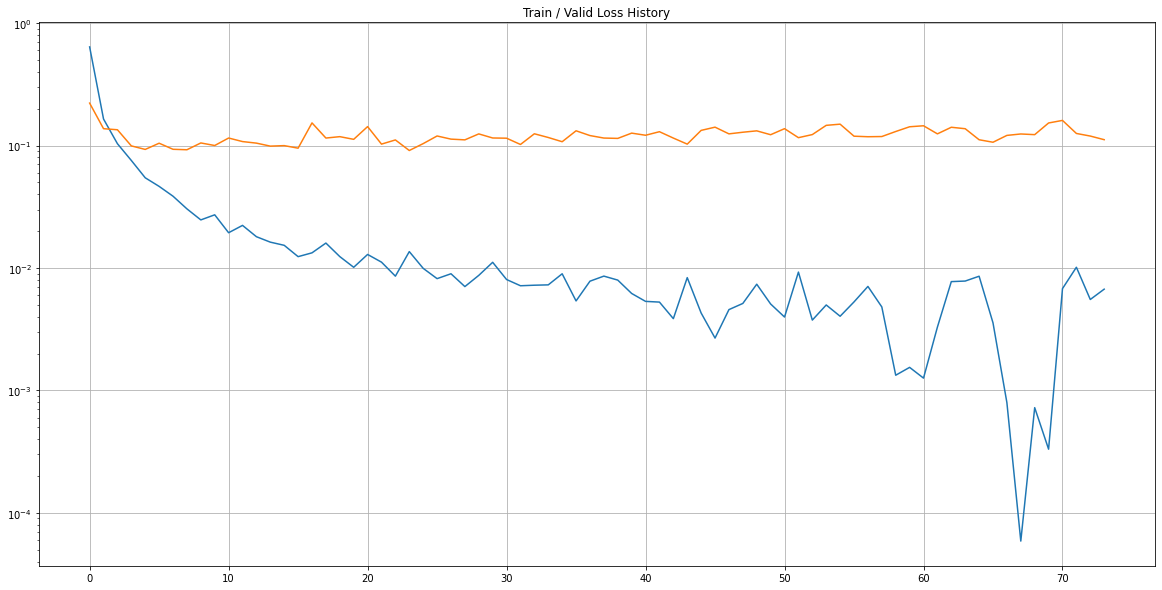

In [33]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## Let's see the result!

In [34]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Validation loss: %.4e" % test_loss)

Validation loss: 8.9984e-02


In [35]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum() # y와 y^ 맞춘 것의 갯수 cnt
total_cnt = float(y[-1].size(0)) # y

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9815


In [36]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [37]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,971,2,0,0,1,0,2,0,2,2
true_1,0,1127,1,2,0,0,1,1,3,0
true_2,8,5,991,8,1,0,1,5,13,0
true_3,0,0,1,999,0,2,0,2,3,3
true_4,1,0,1,0,966,0,5,3,1,5
true_5,2,0,0,8,1,873,3,0,4,1
true_6,2,4,2,1,2,3,943,0,1,0
true_7,1,2,8,4,2,0,0,1002,1,8
true_8,2,1,2,5,3,2,1,2,952,4
true_9,2,3,0,1,7,1,0,4,0,991
